In [6]:
import json
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from os import path
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.decomposition import IncrementalPCA
sys.path.append('../code')
from data_loader import get_dataset
from models.regressor_model import Regressor

In [7]:
with open("../data/data.json", "r") as f:
        data_dict = json.load(f)

unlabeled_dataloader, training_dataloader, validation_dataloader = get_dataset(data_dict=data_dict, batch_size=64)

Dataset loaded
Dataset loaded
Dataset loaded


In [8]:
n_components = 100
ipca = IncrementalPCA(n_components=n_components)
pca_model_path = "pca_model.pkl"

if path.exists(pca_model_path):
    with open(pca_model_path, "rb") as f:
        ipca = pickle.load(f)
else:
    # create PCA incrementally
    for U, _ in tqdm(unlabeled_dataloader):
        ipca.partial_fit(U)
    with open(pca_model_path, "wb") as f:
        pickle.dump(ipca, f)

In [9]:
use_cuda = False
out_features = 10000

model = Regressor([n_components, 4096, out_features])
if use_cuda:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.MSELoss()

if use_cuda:
    criterion = criterion.cuda()

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(len(validation_dataloader))
print(len(training_dataloader))

4
29


Training loss: 1.1579164028167725
Validation loss: 1.0492037236690521



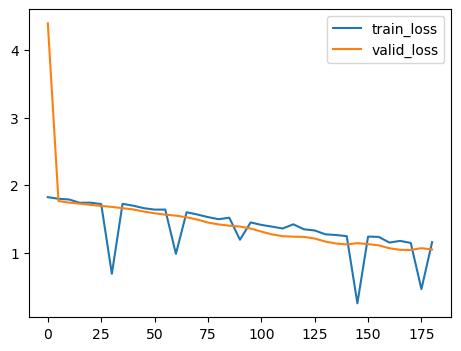

y_pred=tensor([[0.6785, 0.5204, 0.7546,  ..., 0.7859, 0.4008, 0.3969],
        [0.9074, 0.6324, 0.6288,  ..., 0.7117, 0.5703, 0.7631],
        [1.0000, 1.0024, 0.6053,  ..., 0.2346, 0.7794, 0.8288],
        ...,
        [0.5211, 0.9109, 0.4600,  ..., 0.9945, 0.3782, 0.4681],
        [0.6390, 0.6705, 0.5469,  ..., 1.1676, 0.4454, 0.5032],
        [0.5701, 0.6565, 0.5114,  ..., 1.1778, 0.5838, 0.5988]],
       grad_fn=<SoftplusBackward0>)
y_train=tensor([[0.0000, 0.3103, 0.2630,  ..., 2.9819, 2.0144, 0.0000],
        [0.2987, 0.0000, 0.4647,  ..., 1.0000, 2.3951, 0.6415],
        [0.7485, 0.0000, 0.5059,  ..., 1.2079, 1.4330, 1.1110],
        ...,
        [0.0000, 0.0000, 0.5558,  ..., 5.6212, 1.5261, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 3.3702, 1.6781, 0.5059],
        [0.0000, 0.0000, 0.9782,  ..., 5.3709, 1.8359, 0.5460]])



In [10]:
epochs = 20
log_every = 5
val_every = 5
batches = 0
tot_batches = 0

val_losses, val_iter = [], []
train_losses, train_iter = [], []

for i in range(epochs):
    tot_train_loss = 0
    for X_train, y_train in training_dataloader:
        if batches % val_every == 0:
            model.eval()
            tot_val_loss = 0
            val_samples = 0
            for X, y in validation_dataloader:
                
                X_encoded = ipca.transform(X)
                
                X_encoded = torch.tensor(X_encoded, dtype=torch.float32, device='cuda' if use_cuda else 'cpu')
                if use_cuda:
                    y = y.cuda()
                
                y_pred = model.forward(X_encoded)
                
                val_loss = criterion(y_pred, y[:, :out_features])
                tot_val_loss += get_numpy(val_loss)
                val_samples += X.shape[0]

            val_iter.append(batches)
            val_losses.append(tot_val_loss/len(validation_dataloader))

        model.train()
        
        X_encoded = ipca.transform(X_train)
        
        X_encoded = torch.tensor(X_encoded, dtype=torch.float32, device='cuda' if use_cuda else 'cpu')
        
        y_train = y_train[:, :out_features]
        if use_cuda:
            y_train = y_train.cuda()
        
        
        y_pred = model.forward(X_encoded)
        
        train_loss = criterion(y_pred, y_train)
        tot_train_loss += get_numpy(train_loss)
        tot_batches += 1
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    
        if batches % log_every == 0:
            train_iter.append(batches)
            train_losses.append(tot_train_loss/tot_batches)
            tot_train_loss = 0
            tot_batches = 0
            print(f"Epoch {i+1}/{epochs}")
            print(f"Training loss: {train_losses[-1]}\nValidation loss: {val_losses[-1]}")
            print()
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_losses, label='train_loss')
            plt.plot(val_iter, val_losses, label='valid_loss')
            plt.legend()
            plt.show()
            print(f"{y_pred=}")
            print(f"{y_train=}")
            print()
            clear_output(wait=True)
    
        batches += 1